# RoBERTa

In [1]:
import sys
import os

# Get the current working directory
notebook_dir = os.getcwd()

# Construct the path to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the parent directory to the system path
sys.path.append(parent_dir)

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score

from utils import get_x_y, stratified_split
from preprocessing import preprocess_df

2024-06-13 11:16:15.900100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 11:16:17.974634: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 11:16:17.977544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 11:16:23.082999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_name = "roberta-base"
MAX_SEQ_LEN = 128
num_labels = 2

params_dict = {'learning_rate': 1e-5,
                'epochs': 3,
                'batch': 16,
                }

In [2]:
df = pd.read_csv(os.path.join('..', 'data', 'preprocessed_df.csv'), header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [3]:
# split data
train_set, valid_set, test_set = stratified_split(df)
# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

x_train = x_train.values.tolist()
x_test = x_test.values.tolist()
x_valid = x_valid.values.tolist()

In [6]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name)

/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
tokenized_train = tokenizer(x_train, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')
tokenized_valid = tokenizer(x_valid, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')
tokenized_test = tokenizer(x_test, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')

2024-06-13 11:18:00.216325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-13 11:18:00.218539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-13 11:18:00.247520: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

In [13]:
tokenized_train['attention_mask'][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

In [8]:
# Build the RoBERTa model for sequence classification
roberta = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [9]:
input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = roberta(input_ids, attention_mask=mask)[0]

# X = tf.keras.layers.Activation("relu")(embeddings)
# X = tf.keras.layers.Dense(128)(X)
# X = tf.keras.layers.Dropout(0.1)(embeddings)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(embeddings)
# y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(embeddings)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
#model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246471   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    70         'attention_mask[0][0]']      
 SequenceClassification)     2),                                                              

In [10]:
optimizer =  Adam(learning_rate=params_dict['learning_rate'])
loss = BinaryCrossentropy()
acc = BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [11]:
# Train the model
history = model.fit((tokenized_train['input_ids'], tokenized_train['attention_mask']), 
                    y_train,
                    validation_data=((tokenized_valid['input_ids'], tokenized_valid['attention_mask']), y_valid),
                    epochs=params_dict['epochs'], 
                    batch_size=params_dict['batch'])

Epoch 1/3


5625/5625 [==============================] - 8875s 2s/step - loss: 0.1126 - accuracy: 0.9558 - val_loss: 0.0638 - val_accuracy: 0.9766
Epoch 2/3
5625/5625 [==============================] - 8718s 2s/step - loss: 0.0415 - accuracy: 0.9850 - val_loss: 0.3227 - val_accuracy: 0.8885
Epoch 3/3
5625/5625 [==============================] - 8687s 2s/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.1173 - val_accuracy: 0.9653


In [12]:
model.save('models/roberta_latest.h5')

/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
def get_predictions(model, tokenized_x_test):
    predictions = model.predict(dict(tokenized_x_test))
    predictions = np.where(predictions.max(axis=-1) > 0.5, 1, 0)
    return predictions

def acc_loss(history):
    # Visualize Loss & Accuracy

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(np.array(y_true), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def validate_model_roberta(roberta, history, tokenized_x_test, y_true):
    print('#### VALIDATION ####')
    acc_loss(history)

    y_pred = get_predictions(roberta, tokenized_x_test)
    print('Classification report:')
    print(classification_report(y_true, y_pred, zero_division=0))

    conf_matrix(y_true, y_pred)

In [3]:
def roc_score(model_name, y_true, y_pred_proba):
    """
    Plots the ROC curve for the given model and data. Calculates and prints the area under the ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    print(f'AUC: {auc}')
    plt.plot(fpr, tpr, label=model_name+" AUC="+str(round(auc, 3)))
    plt.legend(loc='best')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve for {model_name}')
    plt.show()

#### VALIDATION ####


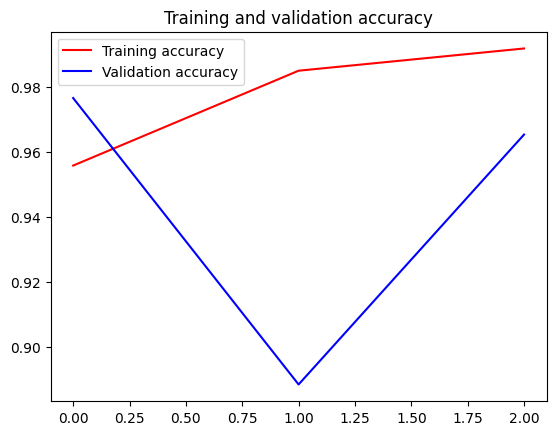

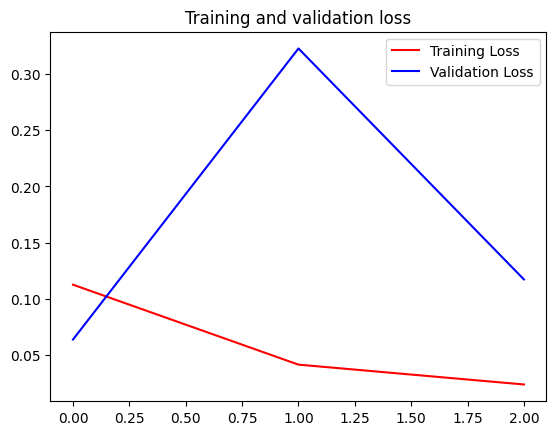

938/938 [==============================] - 846s 900ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15000
           1       0.94      1.00      0.97     15000

    accuracy                           0.97     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.97      0.97      0.97     30000



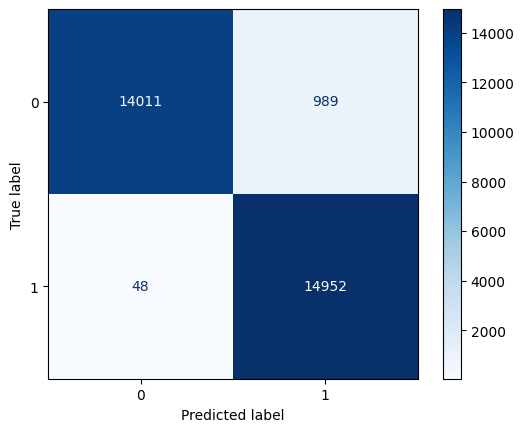

In [15]:
validate_model_roberta(model, history, tokenized_test, y_test)

In [8]:
reloaded_roberta = tf.keras.models.load_model(('/home/mfain/diplomski/masters-thesis/models/roberta_latest.h5'), custom_objects={'TFRobertaForSequenceClassification': TFRobertaForSequenceClassification})

In [9]:
# reloaded preds
print('#### VALIDATION ####')

predictions_proba = reloaded_roberta.predict(dict(tokenized_test))
y_pred = np.where(predictions_proba.max(axis=-1) > 0.5, 1, 0)

print('Classification report:')
print(classification_report(y_test, y_pred, zero_division=0))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1-score: ', f1_score(y_test, y_pred))

conf_matrix(y_test, y_pred)
roc_score('RoBERTa', y_test, predictions_proba.flatten())

#### VALIDATION ####
938/938 [==============================] - 1678s 2s/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15000
           1       0.94      1.00      0.97     15000

    accuracy                           0.97     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.97      0.97      0.97     30000

Accuracy:  0.9654333333333334
Precision:  0.9379587227902892
Recall:  0.9968
F1-score:  0.9664845997220517


NameError: name 'conf_matrix' is not defined

938/938 [==============================] - 1213s 1s/step
Accuracy:  0.9654333333333334
Recall:  0.9968
F1-score:  0.9664845997220517
AUC: 0.9988858622222222


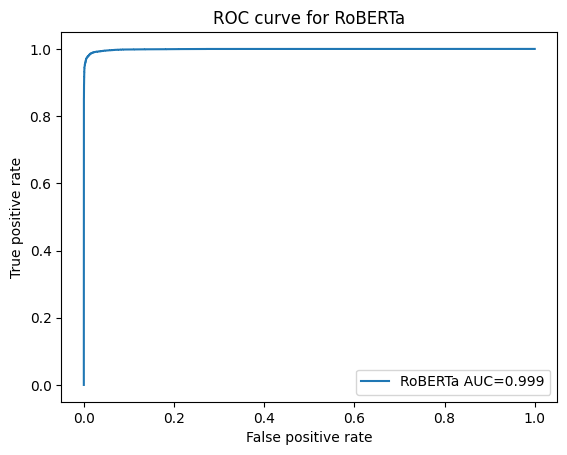

In [13]:
predictions_proba = reloaded_roberta.predict(dict(tokenized_test))
predictions = np.where(predictions_proba.max(axis=-1) > 0.5, 1, 0)

print('Accuracy: ', accuracy_score(y_test, predictions))
print('Recall: ', recall_score(y_test, predictions))
print('F1-score: ', f1_score(y_test, predictions))
roc_score('RoBERTa', y_test, predictions_proba.flatten())

# Predicting on Different Data

In [3]:
def get_extra_data(path):
    #load to df
    data = pd.read_pickle(path)
    data = pd.DataFrame({'text': data})
    # add labels
    labels = np.ones(data.shape[0])
    data['generated'] = labels
    return data

In [6]:
def validate_predictions_roberta(roberta, tokenized_x_test, y_true):
    print('#### VALIDATION ####')

    y_pred = get_predictions(roberta, tokenized_x_test)
    print('Classification report:')
    print(classification_report(y_true, y_pred, zero_division=0))

    conf_matrix(y_true, y_pred)

In [13]:
def predict_data(model, tokenizer, data):
    # prepare data
    data = preprocess_df(data)
    x = data['preprocessed_text'].values.tolist()
    tokenized_x = tokenizer(x, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')
    y = np.array(data['generated'])
    
    validate_predictions_roberta(model, tokenized_x, y)

In [9]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name)

/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
reloaded_model = tf.keras.models.load_model(('models/roberta_latest.h5'), custom_objects={'TFRobertaForSequenceClassification': TFRobertaForSequenceClassification})

2024-05-08 09:13:32.982589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 09:13:32.984641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 09:13:33.000062: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

#### VALIDATION ####
44/44 [==============================] - 46s 1s/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1375
           1       0.00      0.00      0.00         3

    accuracy                           0.93      1378
   macro avg       0.50      0.46      0.48      1378
weighted avg       1.00      0.93      0.96      1378



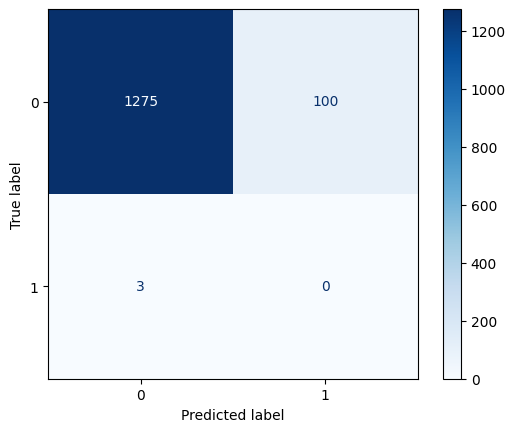

In [19]:
df_essays = pd.read_csv(os.path.join('..', 'data', 'extras', 'train_essays.csv'), header=0)
predict_data(reloaded_model, tokenizer, df_essays)

In [14]:
df_palm = pd.read_csv(os.path.join('..', 'data', 'extras', 'LLM_generated_essay_PaLM.csv'), header=0)
df_falcon = pd.read_csv(os.path.join('..', 'data', 'extras', 'falcon_180b_v1.csv'), header=0)
df_llama = pd.read_csv(os.path.join('..', 'data', 'extras', 'llama_70b_v1.csv'), header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


In [15]:
df_llama.shape, df_falcon.shape, df_palm.shape

((1172, 3), (1055, 3), (1384, 4))

#### VALIDATION ####
113/113 [==============================] - 112s 989ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.90      0.94      3611

    accuracy                           0.90      3611
   macro avg       0.50      0.45      0.47      3611
weighted avg       1.00      0.90      0.94      3611



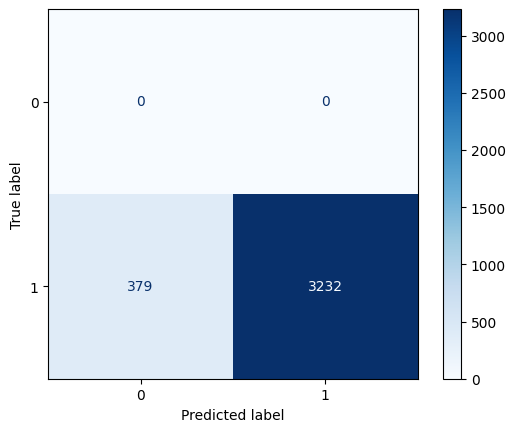

In [21]:
predict_data(reloaded_model, tokenizer, df_extras)